# Capital asset pricing model (CAPM)

## Types of risk

Systematic and unsystematic risk are two types of risk that investors face when they make decisions in the financial markets. 

**Systematic risk**, is the risk that is inherent in the whole market or economy, this risk is faced by all financial instruments and cannot be eliminated using diversification. Examples of systematic risk are interest rate changes, political change, natural disasters, inflation and most recently a global pandemic.

**Unsystematic Risk**, is the risk that is particular to an individual security or company, this risk can be reduced or eliminated through diversification. Examples of unsystematic risk are management changes, product recalls and negative publicity.

## Capital asset pricing model formula

**Capital asset pricing model (CAPM) formula**

$$E(R_{i}) = R_f + \beta_{i}(E(R_m) - R_f)$$

Where:
* E(R_{i}) is the expected return of the security i
* R_f is the risk-free rate of return
* β_1 is the beta coefficient of the security
* E(R_{m}) is the expected return of the market portfolio

**β (Beta) coefficient formula**

$$\beta = \frac{cov(r_i, r_m)}{var(r_m)}$$

The β coefficient represents the systematic risk of a security or portfolio in comparison to the market as a whole. Beta measures the sensitivity of the portfolio or security to changes in the market returns. Beta values to consider:
* β = 1 - indicates the asset shares the same volatility as the market. 
* β > 1 - indicates that the asset is more volatile than the market.
* β < 1 - indicates that the asset is less volatile than the market.

By selecting securities with betas that align with their risk tolerance and investment objectives, investors can build a diversified portfolio that balances risk and return.

## Python programming for the CAPM model

### Import the required libraries

This Python code imports several libraries for data analysis and visualization, which are commonly used in finance, economics, and other fields that deal with data analysis and modeling.
* `numpy` is a library used for mathematical operations.
* `pandas` is a library used for data manipulation and analysis. It will allow us to import the stock data into DataFrames and manipulate the data. 
* `yfinance` is a library used for retrieving financial data from Yahoo Finance, this will allow us to import the relevant stock and market data for the CAPM. 
* `matplotlib.pyplot` is a plotting library used for data visualization.
* `seaborn` is a plotting library used for data visualization.
* `statsmodels.api` is a library used for statistical data analysis, from which we will use the linear regression model.

In [125]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

### Capital Asset Pricing Model class

In [126]:
class CAPM():
    
    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date
        self.alpha = None
        self.beta = None
        
    def download_data(self):
        
        # Data dictionary with key as stock and value as price data
        data = {}
        
        for stock in self.stocks:
            if '^' in stock:
                ticker = yf.download(stock, self.start_date, self.end_date)
            else:
                ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker['Adj Close']
        
        return pd.DataFrame(data)
    
    def initialize(self):
        
        stocks = self.download_data()
        
        stocks = stocks.resample('M').last() 
        
        self.data = pd.DataFrame({'s_adjclose':stocks[self.stocks[0]], 
                                  'm_adjclose':stocks[self.stocks[1]]})
        
        # logarithmic monthly returns
        self.data[['s_returns', 'm_returns']] = np.log((self.data[['s_adjclose', 'm_adjclose']] / 
                                                     self.data[['s_adjclose', 'm_adjclose']].shift(1)))
        
        # Removes NaN values from zero division
        self.data = self.data[1:]
        
        return self.data
    
    def calculate_beta(self, method='linear_regression'):
        # Makes sure the data gets downloaded if initialize hasn't been run
        if not isinstance(self.data, pd.DataFrame):
            print("\nDownloading stock data...\n")
            self.initialize()
            print("\nData downloaded successfully!\n")
        
        # Loop for method type
        if method == "covariance_approach":
            cov_matrix = np.cov(self.data['s_returns'], self.data['m_returns'])
            market_var = np.var(self.data['m_returns'])
            
            beta = cov_matrix[0, 1] / market_var
            self.beta = beta
            
            # Print statements
            print('\n###########################################\n')
            print('# Beta coefficient')
            print('\n###########################################\n')
            print('Output: ', beta)
        elif method == "linear_regression":
            # Linear regression - sm fit
            X = sm.add_constant(self.data['m_returns'])
            model = sm.OLS(self.data['s_returns'], X)
            results = model.fit()
            
            # Model parameters
            alpha = results.params[0]
            beta = results.params[1]
            
            # Store alpha as an attribute of the CAPM class
            self.alpha = alpha
            self.beta = beta
            
            # Print statements
            print('\n###########################################\n')
            print('# Linear regression method parameters')
            print('\n###########################################\n')
            print('Alpha coefficient: ', alpha)
            print('Beta coefficient: ', beta)
        else:
            raise ValueError("Invalid method variable name. Choose either 'covariance_approach' or 'linear_regression'")
            
    def expected_return(self, risk_free_rate):
        # Makes sure the data gets downloaded
        if not isinstance(self.data, pd.DataFrame):
            print("\nDownloading stock data...\n")
            self.initialize()
            print("\nData downloaded successfully!\n")
        
        # Exception handling - Risk Free Rate
        if not 0 <= risk_free_rate <= 1:
            raise ValueError("Risk-free rate must express the percentage in decimal form between 0 and 1.")
            
        # Calculates expected return - double checking 
        if self.beta == None:
            self.calculate_beta()
            expected_return = risk_free_rate * self.beta * (self.data['m_returns'].mean()*12 - risk_free_rate)
            print('\n###########################################\n')
            print('# Expected return \n')
            print('###########################################\n')
            print('Output: ', expected_return)
        else:
            expected_return = risk_free_rate * self.beta * (self.data['m_returns'].mean()*12 - risk_free_rate)
            print('\n###########################################\n')
            print('# Expected return \n')
            print('###########################################\n')
            print('Output: ', expected_return)
            
    def regression_plot(self):
        # Condition to check if data has been downloaded
        if not isinstance(self.data, pd.DataFrame):
            print("\nDownloading stock data...\n")
            self.initialize()
            print("\nData downloaded successfully!\n")
        
        # Condition to check if alpha or beta have been calculated
        if self.beta is None or self.alpha is None:
            self.calculate_beta()
            
        # Set figure size
        plt.figure(figsize = (13,9))
        
        # Set visualisations - scatter and CAPM regression line
        sns.scatterplot(y='s_returns', x='m_returns', data=self.data)
        sns.lineplot(x=self.data['m_returns'], y=self.alpha + self.beta*self.data['m_returns'], color='red')
        
        # Show grid
        plt.grid(True)
        
        # Labels and returns
        plt.xlabel('Market returns')
        plt.ylabel('Asset returns')
        plt.title('Capital Asset Pricing Model - Linear Regression fit')
        
        # Display
        plt.show()
        

In [127]:
stock_and_market = ['AMZN', '^GSPC']
camp = CAPM(stock_and_market, '2015-01-01', '2019-01-01')

In [128]:
camp.calculate_beta()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully!


###########################################

# Linear regression method parameters

###########################################

Alpha coefficient:  0.022119332907151987
Beta coefficient:  1.7694945701390947


In [129]:
camp.expected_return(risk_free_rate=0.02)


###########################################

# Expected return 

###########################################

Output:  0.001355851414018974


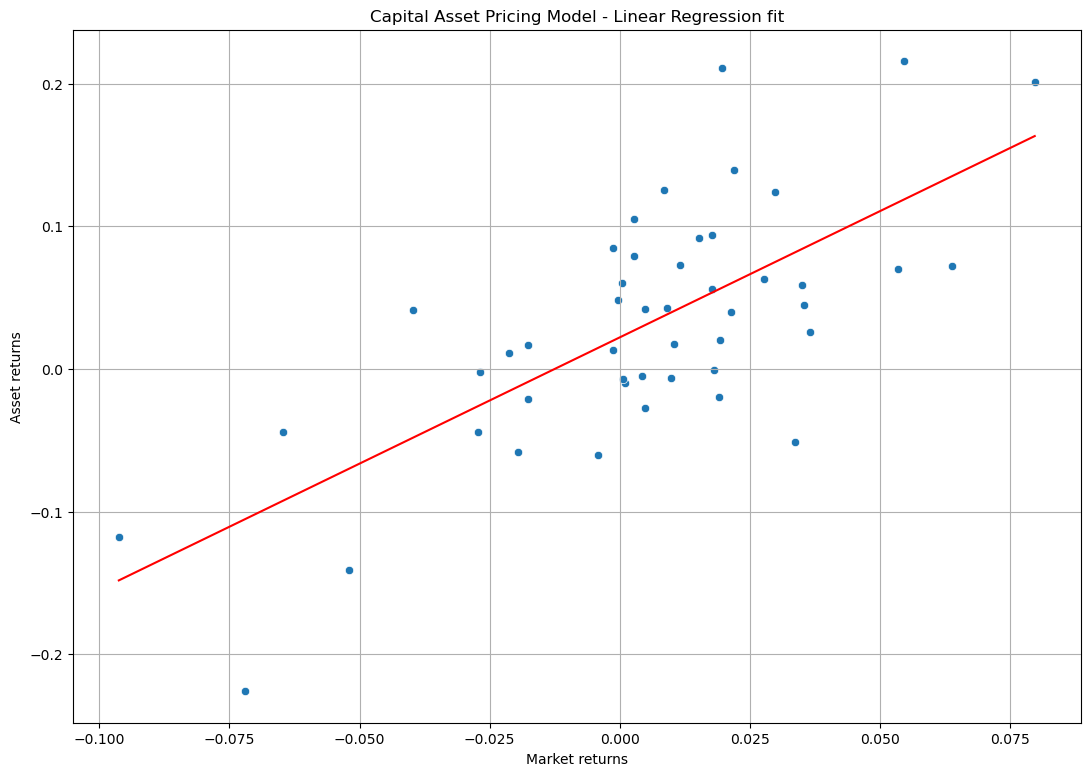

In [130]:
camp.regression_plot()